Measuring the similarity between documents 
========================================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_matlab/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$

This numerical tours exposes a numerical method to measure the similarity between documents using the
optimal transport problem. This entropic regularized version of this problem is solved using a fast computation algorithm based on iterative projections
according to a Kulback-Leiber divergence.
$$ \DeclareMathOperator{\KL}{KL}
\newcommand{\KLdiv}[2]{\KL\pa{#1 | #2}}
\newcommand{\KLproj}{P^{\tiny\KL}}
\def\ones{\mathbb{I}} $$

In [3]:
import numpy as np
import scipy as scp
import pylab as pyl
import gensim as gs
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Entropic Regularization of Optimal Transport
--------------------------------------------
We consider two input histograms $p,q \in \Si_N$, where we denote the simplex in $\RR^N$
$$ \Si_{N} \eqdef \enscond{ p \in (\RR^+)^N }{ \sum_i p_i = 1 }.  $$
We consider the following discrete regularized transport
$$  W_\ga(p,q) \eqdef \umin{\pi \in \Pi(p,q)} \dotp{C}{\pi} - \ga E(\pi).  $$
where the polytope of coupling is defined as
$$ \Pi(p,q) \eqdef \enscond{\pi \in (\RR^+)^{N \times N}}{ \pi \ones = p, \pi^T \ones = q },  $$
where $ \ones \eqdef (1,\ldots,1)^T \in \RR^N $,
and for $\pi \in (\RR^+)^{N \times N}$, we define its entropy as
$$ E(\pi) \eqdef - \sum_{i,j} \pi_{i,j} ( \log(\pi_{i,j}) - 1). $$


When $\ga=0$ one recovers the classical (discrete) optimal transport.
We refer to the monograph [Villani](#biblio) for more details about OT.
The idea of regularizing transport to allows for faster computation is
introduced in [Cuturi](#biblio).


Here the matrix $C \in (\RR^+)^{N \times N} $ defines the ground cost, i.e.
$C_{i,j}$ is the cost of moving mass from a bin indexed by $i$ to a bin indexed by $j$.


The regularized transportation problem can be re-written as a projection
$$ W_\ga(p,q) = \ga \umin{\pi \in \Pi(p,q)} \KLdiv{\pi}{\xi}
	\qwhereq
	\xi_{i,j} = e^{ -\frac{C_{i,j}}{\ga} }  $$
of $\xi$ according to the Kullback-Leibler divergence.
The Kullback-Leibler divergence between $\pi, \xi \in (\RR^+)^P$ is
$$ \KLdiv{\pi}{\xi} = \sum_{i,j} \pi_{i,j} \pa{ \log\pa{ \frac{\pi_{i,j}}{\xi_{i,j}} } - 1}. $$


This interpretation of regularized transport as a KL projection and its numerical
applications are detailed in [BenamouEtAl](#biblio).


Given a convex set $\Cc \subset \RR^N$, the projection according to the Kullback-Leiber divergence is defined as
$$ \KLproj_\Cc(\xi) = \uargmin{ \pi \in \Cc } \KLdiv{\pi}{\xi}. $$

Iterative Bregman Projection Algorithm
--------------------------------------
Given affine constraint sets $ (\Cc_1,\ldots,\Cc_K) $, we aim at computing
$$   \KLproj_\Cc(\xi) \qwhereq \Cc = \Cc_1 \cap \ldots \cap \Cc_K. $$


This can be achieved, starting by $\pi_0=\xi$, by iterating
$$ \forall \ell \geq 0, \quad \pi_{\ell+1} =  \KLproj_{\Cc_\ell}(\pi_\ell), $$
where the index of the constraints should be understood modulo $K$,
i.e. we set $ \Cc_{\ell+K}=\Cc_\ell $.


One can indeed show that $\pi_\ell \rightarrow \KLproj_\Cc(\bar \pi)$.
We refer to [BauschkeLewis](#biblio) for more details about this
algorithm and its extension to compute the projection on the intersection of
convex sets (Dikstra algorithm).

Iterative Projection for Regularized Transport aka Sinkhorn's Algorithm
-----------------------------------------------------------------------
We can re-cast the regularized optimal transport problem within this
framework by introducing
$$ \Cc_1 \eqdef \enscond{\pi \in (\RR^+)^{N \times N} }{\pi \ones = p}
\qandq
 \Cc_2 \eqdef \enscond{\pi \in (\RR^+)^{N \times N} }{\pi^T \ones = q}. $$


The KL projection on $\Cc_1$ sets are easily computed by divisive
normalization of rows. Indeed, denoting
$ \pi = \KLproj_{\Cc_1}(\bar \pi) $, one has
$$ \forall (i,j), \quad
  \pi_{i,j} = \frac{ p_i \bar\pi_{i,j} }{ \sum_{s} \bar\pi_{i,s} } $$
and similarely for $\KLproj_{\Cc_1}(\bar \pi) $ by replacing rows by
colums.

A fundamental remark is that, if $\bar\pi = \diag(a) \xi \diag(b)$ (a
so-called diagonal scaling of the kernel $\xi$), then one has
$$ \KLproj_{\Cc_1}(\bar \pi) = \diag(\tilde a) \xi \diag(b)
  \qandq
  \KLproj_{\Cc_2}(\bar \pi) = \diag(a) \xi \diag(\tilde b)$$
 where the new scaling reads
  $$ \tilde a = \frac{p}{\xi(b)}  \qandq  \tilde b = \frac{q}{\xi^T(a)} $$
where $\frac{\cdot}{\cdot}$ is entry-wise division.


This means that the iterates of Bregman iterative projections, starting
with $ a_0 \eqdef \ones $ always have the form
$ \pi_\ell = \diag(a_\ell) \xi \diag(b_\ell)  $
and these diagonal scaling weights are updated as follow
$$  a_{\ell+1} \eqdef \frac{p}{\xi(b_\ell)}
      \qandq
  b_{\ell+1} \eqdef \frac{q}{\xi^T(a_{\ell+1})}. $$
This algorithm is in fact the well known Sinkhorn algorithm [Sinkhorn](#biblio).

Embedding the words with word2vec
------------------------------
Each word is mapped to a high-dimentional space using Google's word2vec embedding (see [Mikolov](#biblio)).

Load Google's pre-trained Word2Vec model. This will take some time, estimated amount of RAM needed: 5GB. 

In [4]:
w2v_model = gs.models.Word2Vec.load_word2vec_format('word2vec/GoogleNews-vectors-negative300.bin.gz', binary=True)  

Distances between documents using histograms of words
-----------------------
We first will use the approach explained in [Kusner](#biblio) consisting in solving the transportation problem between histograms of texts. After a preprocessing step (see below for details), each document is mapped to an histogram counting the occurences of the words in that document (using as support all the words appearing in at least on of the documents). 

The words are then embedded in a high-dimentional space using the word2vec model. The distance between the two docments is then the minimum transportation cost between the two histograms :
$$d = \min_{\pi \in \Pi(p,q)}\sum_{i,j}\pi_{i,j} C_{i,j}$$
with the weight constraints $$\pi \in \Pi(p,q) = \enscond{\pi \in (\RR^+)^{N \times N}}{ \pi \ones = p, \pi^T \ones = q }$$
using:
- The euclidian norm in the embedding space as transportation cost $C_{i,j}$,
- Weights $p$ and $q$ representing the occurences of words on each document.

Instead of directly solving this problem, we rather implement Sinkhorn's algorithm on its entropic regularized version described in [Sinkhorn](#biblio). Note that the most (equally) computationally intensive steps are:
- The calculus of the cost matrix (we gained a factor 10 by using the scipy.spatial library
- Sinkhorn's algorithm

__Preprocessing__

Load documents (NY Times articles concerning sports or politics) and select 2 of them.

In [5]:
with open("data/sport1.txt") as f:
    sport1 = f.read()
with open("data/sport2.txt") as f:
    sport2 = f.read()
with open("data/politics1.txt") as f:
    politics1 = f.read()
with open("data/politics2.txt") as f:
    politics2 = f.read()
    
d1 = politics1
d2 = politics2

Lowerize the words and remove the digits.

In [6]:
d1_no_digit = ''.join([c.lower() for c in d1 if not c.isdigit()])
d2_no_digit = ''.join([c.lower() for c in d2 if not c.isdigit()])

Then tokenize the text, i.e. break it into a vector of words (this process is more complicated that it seems to be, see documentation for examples). In this step, the ponctuation is also removed.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

d1_vect = CountVectorizer().build_tokenizer()(d1_no_digit)
d2_vect = CountVectorizer().build_tokenizer()(d2_no_digit) 

Remove the stopwords, refering to the most common words in a language and thus carrying little to no specific meaning. Those stop words are taken from the SMART list described in [Salton](#biblio). 

In [8]:
from nltk.corpus import stopwords
from numpy import random

stop_words = np.array(stopwords.words('english'))
sample = random.choice(len(stop_words), 5)
print("Some examples of stopwords:", stop_words[sample])

d1_clean = [w for w in d1_vect if w not in stop_words]
d2_clean = [w for w in d2_vect if w not in stop_words]

Some examples of stopwords: ['what' 'an' 'each' 'very' 'by']


Remove the words that are not known by the model.

In [9]:
to_delete_1 = []
for i in range(len(d1_clean)):
    try:
        w2v_model[d1_clean[i]]
    except KeyError:
        to_delete_1 = to_delete_1 + [d1_clean[i]]
d1_ready = [w for w in d1_clean if w not in to_delete_1]

to_delete_2 = []
for i in range(len(d2_clean)):
    try:
        w2v_model[d2_clean[i]]
    except KeyError:
        to_delete_2 = to_delete_2 + [d2_clean[i]]
d2_ready = [w for w in d2_clean if w not in to_delete_2]

n_unknown = len(np.unique(to_delete_1 + to_delete_2))

__Build the histograms__

Build the word histograms using as support the words appearing in at least one of the documents.

In [10]:
from collections import Counter

support = np.union1d(d1_ready, d2_ready)
d1_count = Counter(support) + (Counter(d1_ready))
d2_count = Counter(support) + (Counter(d2_ready)) 

words, p = zip(*d1_count.items())
words, q = zip(*d2_count.items())
words = np.array(words)

N = len(words)
p = np.array(p) - 1
q = np.array(q) - 1

print("Unknown words: %i/%i (%.2f%%)" %(n_unknown, N, 100 * n_unknown / N))

Unknown words: 7/442 (1.58%)


Add some minimal mass and normalize

In [11]:
vmin = .01;
normalize = lambda p: p / np.sum(p)
p = normalize(p + np.max(p) * vmin)
q = normalize(q + np.max(q) * vmin)

Display the word histograms.

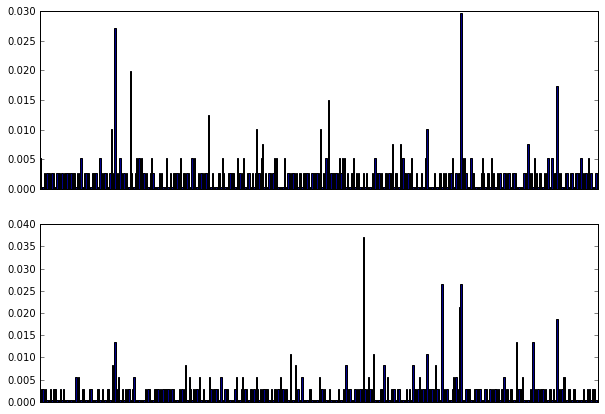

In [12]:
N = len(words)
t = np.arange(0,N) / N

plt.figure(figsize = (10,7))

plt.subplot(2, 1, 1)
plt.bar(t, p, width = 1/len(t), color = "darkblue")
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')

plt.subplot(2, 1, 2)
plt.bar(t, q, width = 1/len(t), color = "darkblue")
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')

plt.show()

Build the cost matrix.

In [13]:
from scipy import spatial

Coords = w2v_model[words]
C = spatial.distance.squareform(spatial.distance.pdist(Coords))

Set regularization strength $\gamma$.

In [14]:
gamma = 1

Compute Gibbs Kernel

In [15]:
xi = np.exp(-C**2 / gamma)

__Compute the optimal transportation policy__

Perform Sinkhorn's algorithm.

In [16]:
from numpy import linalg

b = np.ones(N)
niter = 100
Err_p = []
Err_q = []

for i in range(niter):
    a = p / (np.dot(xi, b))
    Err_q = Err_q + [linalg.norm(b * np.dot(xi, a) - q) / linalg.norm(q)]
    b = q / (np.dot(np.transpose(xi), a))
    Err_p = Err_p + [linalg.norm(a * np.dot(np.transpose(xi) ,b) - p) / linalg.norm(p)]

Display the violation constraints.

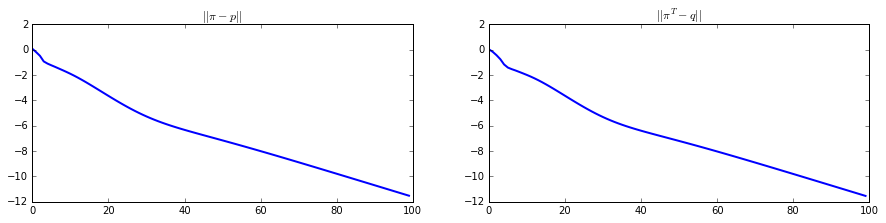

In [17]:
plt.figure(figsize = (15, 7))

plt.subplot(2, 2, 1)
plt.title("$||\pi - p||$")
plt.plot(np.log(np.asarray(Err_p)), linewidth = 2)

plt.subplot(2, 2, 2)
plt.title("$||\pi^T - q||$")
plt.plot(np.log(np.asarray(Err_q)), linewidth = 2)

plt.show()

Calculate the optimal transportation policy and the distance between the 2 documents.

In [18]:
Pi = np.dot(np.dot(np.diag(a), xi), np.diag(b))
d = np.sum(C * Pi)

print("Distance between the two documents: %.2f" %d)

Distance between the two documents: 2.49


__Display results__

Display the hottest words (the most "transported" ones) by removing the transportations between identic words.

In [19]:
print("Hottest words:")
hot_idx = np.where((Pi - np.max(Pi) * np.diag(np.ones(N))) > 0.35 * np.max(Pi))
for i in range(len(hot_idx[0])):
    print(words[hot_idx[0][i]], "-->",words[hot_idx[1][i]],"p = %.2f, q = %.2f, pi = %.2f" %(p[hot_idx[0][i]], q[hot_idx[1][i]], Pi[hot_idx][i]))

Hottest words:
obama --> clinton p = 0.03, q = 0.04, pi = 0.01


Display the whole (log) transportation policy. Notice the white diagonal due to the fact the we artificially added a minimum weight to the histograms. 

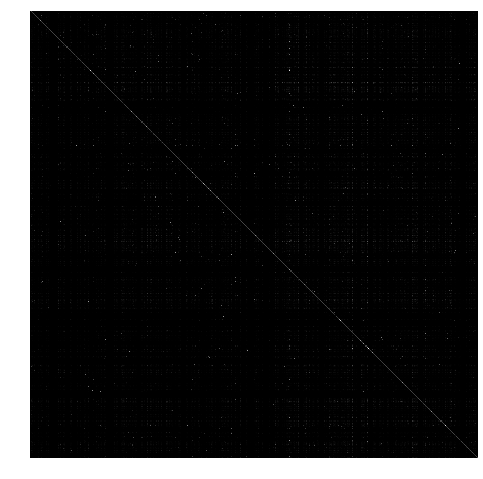

In [20]:
Pi = np.dot(np.dot(np.diag(a), xi), np.diag(b))

plt.figure(figsize=(8, 8))
imageplot(np.log(Pi + 1e-4))
plt.show()

The whole function:

In [138]:
import numpy as np
import scipy as scp
import pylab as pyl
import gensim as gs
import matplotlib.pyplot as plt

from numpy import linalg

from time import time
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from scipy import spatial

stop_words = set(stopwords.words('english'))
#pickle.load(open("data/C_most_common.p", 'rb'))
#pickle.load(open("data/keys_most_common.p", 'rb'))

def distance(d1, d2, gamma, niter, most_common = 1, verbose = 0):

    tm = time()
    # lowerise and remove digis 
    d1_no_digit = ''.join([c.lower() for c in d1 if not c.isdigit()])
    d2_no_digit = ''.join([c.lower() for c in d2 if not c.isdigit()])
    
    # tokenize
    d1_vect = CountVectorizer().build_tokenizer()(d1_no_digit)
    d2_vect = CountVectorizer().build_tokenizer()(d2_no_digit)
    
    # remove stop words
    d1_clean = [w for w in d1_vect if w not in stop_words]
    d2_clean = [w for w in d2_vect if w not in stop_words]
    
    # remove unknown words from the model (and from the most_common if option activated)
    to_delete_1 = []
    for i in range(len(d1_clean)):
        try:
            w2v_model[d1_clean[i]]
            if most_common != 0:
                keys[d1_clean[i]]
        except KeyError:
            to_delete_1 = to_delete_1 + [d1_clean[i]]
    d1_ready = [w for w in d1_clean if w not in to_delete_1]
    
    to_delete_2 = []
    for i in range(len(d2_clean)):
        try:
            w2v_model[d2_clean[i]]
            if most_common != 0:
                keys[d2_clean[i]]
        except KeyError:
            to_delete_2 = to_delete_2 + [d2_clean[i]]
    d2_ready = [w for w in d2_clean if w not in to_delete_2]

    n_unknown = len(np.unique(to_delete_1 + to_delete_2))
    
    # count occurences
    support = np.union1d(d1_ready, d2_ready)
    
    # case when len(d1_ready) = 0 or len(d2_ready) == 0: return inf. 
    try:
        d1_count = Counter(support) + (Counter(d1_ready))
        d2_count = Counter(support) + (Counter(d2_ready)) 
    except ValueError:
        return np.float('inf')
    
    words, p = zip(*d1_count.items())
    words, q = zip(*d2_count.items())
    words = np.array(words)
    N = len(words)
    p = np.array(p) - 1
    q = np.array(q) - 1
    
    # normalize and add default mass
    vmin = .02;
    normalize = lambda p: p/np.sum(p)
    p = normalize(p+np.max(p)*vmin)
    q = normalize(q+np.max(q)*vmin)

    t = np.arange(0,N) / N
    
    if verbose == 3:
        print("Preprocessing: ", -tm + time())
    tm = time()
    # built cost matrix
    if most_common == 0:
        Coords = w2v_model[words]
        C = spatial.distance.squareform(spatial.distance.pdist(Coords))
    else: 
        keys_words = [keys[w] for w in words]
        C = C_most_common[np.ix_(keys_words, keys_words)]
    xi = np.exp(-C**2 / gamma)
    
    if verbose == 3:
        print("Cost matrix: ", -tm + time())
    tm = time()
    # Sinkhorn's algorithm
    b = np.ones(N)
    Err_p = []
    Err_q = []

    for i in range(niter):
        a = p/(np.dot(xi,b))
        Err_q = Err_q + [linalg.norm(b*np.dot(xi,a) - q)/linalg.norm(q)]
        b = q /(np.dot(np.transpose(xi),a))
        Err_p = Err_p + [linalg.norm(a*np.dot(np.transpose(xi),b) - p)/linalg.norm(p)]
   
    if verbose == 3:
        print("Sinkhorn: ", -tm + time())
    tm = time()
    # calculate pi and d
    Pi = np.dot(np.dot(np.diag(a),xi),np.diag(b))
    d = np.sum(C * Pi)
    
    # display
    if verbose == 1 or verbose == 2:
        print("Distance between the two documents: %.2f" %d)
        print("---")
        print("Hottest words:")
        hot_idx = np.where((Pi - np.max(Pi) * np.diag(np.ones(N))) > 0.70 * np.max(Pi))
        for i in range(len(hot_idx[0])):
            print(words[hot_idx[0][i]], "-->",words[hot_idx[1][i]],"pi = %.2f" %Pi[hot_idx][i])
        print("---")
        print("Unknown words: %i/%i (%.2f%%)" %(n_unknown, N, 100 * n_unknown / N))
        print("---")
        
    #plot
    if verbose == 2:
        plt.figure(figsize = (15, 7))
        
        plt.subplot(2, 2, 1)
        plt.title("$||\pi -p||$")
        plt.plot(np.log(np.asarray(Err_p)), linewidth = 2)
        
        plt.subplot(2, 2, 2)
        plt.title("$||\pi^T -q||$")
        plt.plot(np.log(np.asarray(Err_q)), linewidth = 2)
        
        plt.show()
        
        plt.figure(figsize=(7,7))
        imageplot(np.log(Pi+1e-5))
        
        plt.show()
    
    return d

Run some tests with the whole function: first a toy example. Note that similar word are mapped to each other and that the transportation policy for the most transported words almost sums to 1.   

In [255]:
s1 = "Obama speaks to the media in Illinois"
s2 = "The President greets the press in Chicago"

distance(sport1,sport2, .1, 100, verbose = 3, most_common = 1)

Preprocessing:  0.012215137481689453
Cost matrix:  0.002424955368041992
Sinkhorn:  0.01310110092163086


1.784102456870464

Then an example on articles delaing with different topics. Note that articles in the same category are more similar to each other.

In [272]:
print("Distance(sport1, sport2) = %.2f " %distance(sport1, sport2, .1, 100))
print("Distance(politics1, politics2) = %.2f " %distance(politics1, politics2, .1, 100))
print("Distance(sport1, politics2) = %.2f " %distance(sport1, politics2, .1, 100))
print("Distance(politics1, sport2) = %.2f " %distance(politics1, sport2, .1, 100))

Distance(sport1, sport2) = 1.78 
Distance(politics1, politics2) = 1.89 
Distance(sport1, politics2) = 2.09 
Distance(politics1, sport2) = 2.22 


Influence of $\lambda$ and the number of iterations: those parameters have to be tuned carefully depending on the type of documents we are dealing with.

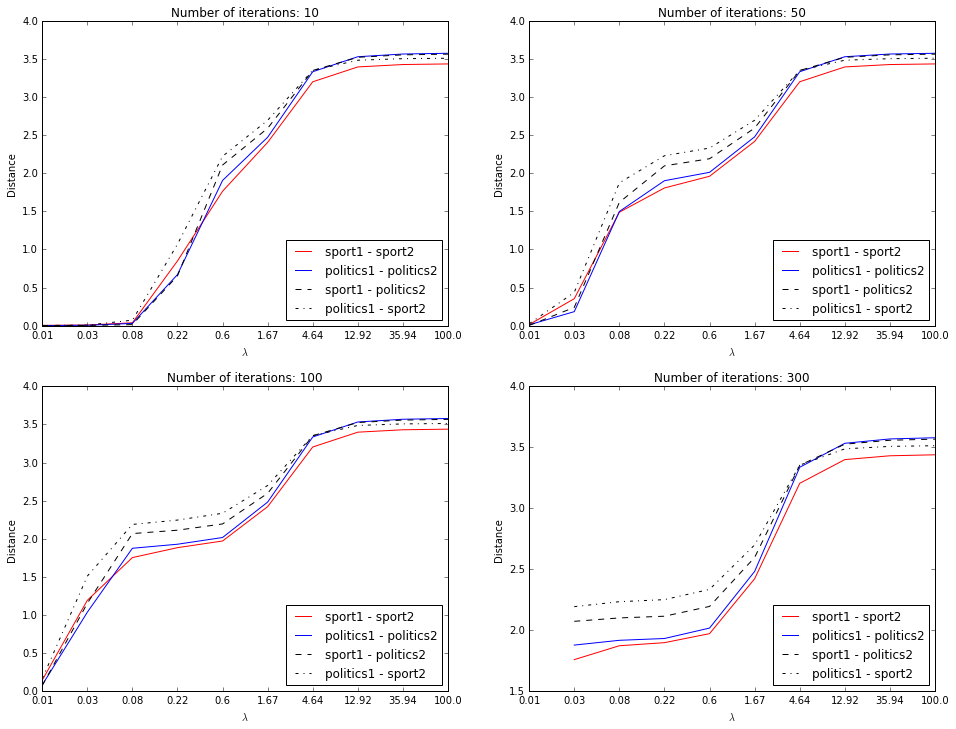

array([[        nan,         nan,         nan,         nan],
       [ 1.75610757,  1.87550865,  2.0706795 ,  2.19109015],
       [ 1.87014864,  1.91471882,  2.09857907,  2.23186783],
       [ 1.89536766,  1.92954976,  2.11260899,  2.24889113],
       [ 1.96940158,  2.01527587,  2.19295802,  2.33311524],
       [ 2.42005659,  2.48045342,  2.59549886,  2.69822563],
       [ 3.20426141,  3.33592747,  3.35227415,  3.35371376],
       [ 3.39894874,  3.53302576,  3.52582032,  3.48729884],
       [ 3.43047726,  3.56879408,  3.55798882,  3.50760637],
       [ 3.43852182,  3.57845482,  3.56720107,  3.51309063]])

In [310]:
lambda_list = np.logspace(-2,2,10)
niter_list = [10, 50, 100, 300]
plt.figure(figsize = (16,12))
    
for it in range(len(niter_list)):
    niter = niter_list[it]
    results = np.zeros([len(lambda_list), 4])

    for i in range(len(lambda_list)):
        lambd = lambda_list[i]
        results[i, 0] =  distance(sport1, sport2, lambd, niter)
        results[i, 1] =  distance(politics1, politics2, lambd, niter)
        results[i, 2] =  distance(sport1, politics2, lambd, niter)
        results[i, 3] =  distance(politics1, sport2, lambd, niter)
    
    plt.subplot(2,2,it + 1)
    plt.plot(results[:, 0] , color = 'red')
    plt.plot(results[:, 1] , color = 'blue')
    plt.plot(results[:, 2] , 'r--', color = 'black')
    plt.plot(results[:, 3] , 'r-.', color = 'black')
    plt.xticks(np.arange(10), np.around(lambda_list, 2))
    plt.xlabel("$\lambda$")
    plt.ylabel("Distance")
    plt.title("Number of iterations: %d" %niter)
    plt.legend(['sport1 - sport2', 'politics1 - politics2', 'sport1 - politics2', 'politics1 - sport2'], loc=4)

plt.show()
results

__Supervised learning : Text classification__

Run some supervised learning tests with the Reuters dataset: the documents are labelled with one category. Load the train test:

In [25]:
reuters_train = []
with open("data/reuters_train.txt") as f:
    for new in f:
        category, left = new.split("\t")
        text = left.split(" reuter")[0]
        reuters_train = reuters_train + [(category, text)]

Test a new sample (labelled as "trade"). This may take approximately 1 minute.

In [274]:
%%time
test = "asian exporters fear damage from japan rift mounting trade friction between the and japan has raised fears among many asia exporting nations that the row could inflict far reaching economic damage businessmen and officials said they told reuter correspondents asian capitals move against japan might boost protectionist sentiment the and lead curbs american imports their products but some exporters said that while the conflict would hurt them the long run the short term tokyo loss might their gain the has said will impose mln dlrs tariffs imports japanese electronics goods april retaliation for japan alleged failure stick pact not sell semiconductors world"
distances = []
for i in range(len(reuters_train)):
    category, text = reuters_train[i]
    distances = distances + [(category, distance(test, text, .1, 10))]
    
distances.sort(key=lambda x: x[1])
print("Closest neighbors:")
distances[:5]

KeyboardInterrupt: 

__Supervised learning : Sentiment analysis__

Run some supervised learning tests with the Twitter dataset: each tweet is labelled as positive, neutral or negative.

In [283]:
twitter = []
with open("data/twitter.txt") as f:
    for new in f:
        category, left = new.split("\"\t")
        category = category[1:]
        text = left[:-2]
        # remove unknown words
        text_no_digit = ''.join([c.lower() for c in text if not c.isdigit()])
        text_vect = CountVectorizer().build_tokenizer()(text_no_digit)
        text_clean = [w for w in text_vect if w not in stop_words]
        delete = False
        for i in range(len(text_clean)):
            try:
                w2v_model[text_clean[i]]
            except KeyError:
                delete = True
        if not delete:
            twitter = twitter + [(category, text)]
            
np.random.shuffle(twitter)
N = len(twitter)
twitter_train = twitter[:3*N//4]
twitter_test  = twitter[3*N//4:]

Test a new sample.

In [285]:
%%time
print(twitter_test[1])
test = twitter_test[1][1]

distances = []
for i in range(len(twitter_train)):
    category, text = twitter_train[i]
    distances = distances + [(category, distance(text, test, 1, 10))]
    
distances.sort(key=lambda x: x[1])
print("Closest neighbors:")
distances[:5]

('neutral', ' night  twitter')
Closest neighbors:
CPU times: user 597 ms, sys: 6.22 ms, total: 603 ms
Wall time: 608 ms


Calibrate the number of iterations

In [305]:
%%time
iteration_list = [50]
results = []

for i in range(len(iteration_list)):
    niter = iteration_list[i]
    print("Setting niter to %d" %niter)
    err = 0.
    for j in range(len(twitter_test)):
        category_test, text_test = twitter_test[j]
        d_min = np.float('inf')                    
        for k in range(len(twitter_train)):
            category_train, text_train = twitter_train[k]
            try:
                d = distance(text_test, text_train, 1, niter)
            except ValueError:
                d = np.float('inf')
            if d < d_min and d != 0:
                d_min = d
                category_min = category_train

        if category_min != category_test:
            err += 1.
    results = results + [err / len(twitter_test)]

Setting niter to 80
Setting niter to 100


KeyboardInterrupt: 

Calibrate $\lambda$ on the 1-NN algorithm. 

In [289]:
%%time
lambda_list = np.logspace(-1,1,10)
niter = 50
results = []

for i in range(len(lambda_list)):
    lambd = lambda_list[i]
    print("Setting lambda to %.2f" %lambd)
    err = 0.
    for j in range(len(twitter_test)):
        category_test, text_test = twitter_test[j]
        d_min = np.float('inf')                    
        for k in range(len(twitter_train)):
            category_train, text_train = twitter_train[k]
            try:
                d = distance(text_test, text_train, lambd, niter)
            except ValueError:
                d = np.float('inf')
            if d < d_min and d != 0:
                d_min = d
                category_min = category_train

        if category_min != category_test:
            err += 1.
    results = results + [err / len(twitter_test)]

Setting lambda to 0.10
Setting lambda to 0.17
Setting lambda to 0.28
Setting lambda to 0.46
Setting lambda to 0.77
Setting lambda to 1.29
Setting lambda to 2.15
Setting lambda to 3.59
Setting lambda to 5.99
Setting lambda to 10.00
CPU times: user 1h 44min 34s, sys: 46.7 s, total: 1h 45min 21s
Wall time: 1h 48min 17s


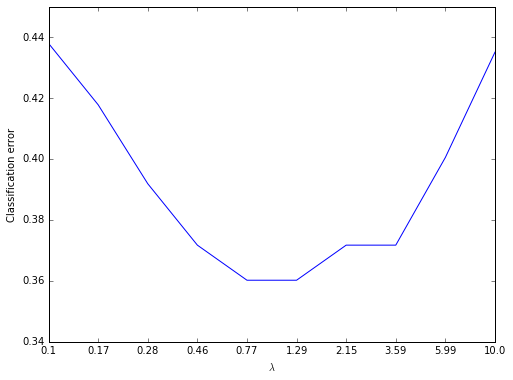

[0.43804034582132567,
 0.41786743515850144,
 0.3919308357348703,
 0.37175792507204614,
 0.36023054755043227,
 0.36023054755043227,
 0.37175792507204614,
 0.37175792507204614,
 0.40057636887608067,
 0.43515850144092216]

In [296]:
plt.figure(figsize = (8,6))
plt.plot(results)
plt.xticks(np.arange(10), np.around(lambda_list, 2))
plt.xlabel("$\lambda$")
plt.ylabel("Classification error")
plt.ylim([0.34, 0.45])
plt.show()
results

__Unsupervised learning: text classification__

Compute the distance matrix D.

In [291]:
%%time
data = [e[1] for e in twitter]
N = len(data)
D_temp = np.zeros([N,N])

for i in range(N):
    if i % (N//10) == 0:
        print("Step i = %d" %i)
    for j in range(i + 1, N):
        D_temp[i, j] =  distance(data[i], data[j], 1, 10)
        
D = D_temp + np.transpose(D_temp)

import pickle
pickle.dump(D, open("D.p", 'wb'))

Step i = 0


ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
%%time

import numpy

import scipy
import scipy.spatial.distance

import sys


from numba import jit

import theano

try:
    from time import perf_counter
except:
    from time import time
    perf_counter = time


INF = float('inf')


# @autojit
def closest_medoids_cost(distances, medoid_ids):
    """
    Computing the closest medoids and the cost of the new configuration
    using numpy
    """
    closest_ids = numpy.argmin(distances[:, medoid_ids], axis=1)
    return closest_ids, numpy.sum(distances[:, closest_ids])


@jit
def closest_medoids_numba(distances, medoid_ids, clustering):
    """
    Computing the closest medoids and the cost of the new configuration
    using a simple loop optimized with Numba
    """
    n_instances = distances.shape[0]
    tot_cost = 0
    for i in range(n_instances):
        best_medoid = i
        best_cost = INF
        for j in medoid_ids:
            cost = distances[i, j]
            if cost < best_cost:
                best_cost = cost
                best_medoid = j

        tot_cost += best_cost
        clustering[i] = best_medoid

    return tot_cost


def create_theano_cost_function(distances):
    """
    Creating the function to compute the closest medoids and the cost
    of that configuration using Theano
    """
    #
    # the distance matrix is a shared var
    #
    D = theano.shared(distances)
    M = theano.tensor.bvector()
    #
    # Some tricky stuff here, I am using max_and_argmax to get both
    # things so I shall use an inverted distance matrix
    #
    Inf = theano.shared(float('inf'))
    D_meds = theano.tensor.switch(M, -D, -Inf)
    # D_meds = theano.printing.Print('DM')(D_meds_a)
    Closest, Idx = theano.tensor.max_and_argmax(D_meds, axis=1)
    # Closest = theano.printing.Print('CLS')(Closest_a)
    # Idx = theano.printing.Print('IDX')(Idx_a)
    Cost = theano.tensor.sum(Closest)
    return theano.function([M], [-Cost, Idx])


def medoid_assoc_to_clustering(clustering):
    """
    Converting a clustering by medoid ids into one with sequential ids
    (starting from 0)
    """
    medoids_to_clusters = set(clustering)

    clustering_assoc = {medoid_id: cluster_id for cluster_id, medoid_id
                        in enumerate(medoids_to_clusters)}
    clustering_ids = [clustering_assoc[medoid_id] for medoid_id in clustering]
    return clustering_ids

# @autojit


def pam(distances,
        k,
        n_iters=100,
        delta_cost=1e-5,
        rand_gen=None,
        medoids_2_clusters=False,
        theano=False):
    """
    Partitioning Around Medoids (PAM) implementation of K-Medoids
    """
    n_instances = distances.shape[0]
    stop = False
    iter = 0

    if theano:
        closest_medoids_theano = create_theano_cost_function(distances)

    if rand_gen is None:
        rand_gen = numpy.random.RandomState(1337)

    instance_ids = [i for i in range(n_instances)]
    #
    # using an array of bits
    medoid_ids_vec = numpy.zeros(n_instances, dtype=bool)

    # setting k random medoids
    medoid_ids = rand_gen.choice(instance_ids, k, replace=False)
    # medoid_ids = [1, 7]
    medoid_ids_vec[medoid_ids] = True

    #
    # using another array for the medoid correspondences
    # assigning to the closest medoid
    if not theano:
        clustering = numpy.zeros(n_instances, dtype='int32')
        cost = closest_medoids_numba(distances, medoid_ids, clustering)

    else:
        cost, clustering = closest_medoids_theano(medoid_ids_vec)

    print('Initial cost {0} clustering {1} medoids {2} vec {3}'.
          format(cost, clustering, medoid_ids, medoid_ids_vec))

    best_cost = cost
    best_clustering = clustering
    curr_best_cost = cost
    curr_best_clustering = numpy.copy(clustering)
    curr_best_medoid_ids = medoid_ids
    curr_best_medoid_ids_vec = medoid_ids_vec

    while iter < n_iters and not stop:

        iter_start_t = perf_counter()
        #
        # Maximization step
        #
        for i, medoid_id in enumerate(medoid_ids):

            avg_swap_t = 0
            #
            # Trying to swap each other instance
            #
            for j in instance_ids:

                swap_start_t = perf_counter()

                # j is not a medoid
                if not medoid_ids_vec[j]:

                    # remove medoid
                    # medoid_ids_cp = set(medoid_ids)
                    # medoid_ids_cp.remove(medoid_id)
                    # add instance
                    # medoid_ids_cp.add(j)

                    # print('\n curr vec', medoid_ids_vec)
                    medoid_ids_vec[medoid_id] = False
                    medoid_ids_vec[j] = True

                    medoid_ids_cp, = numpy.where(medoid_ids_vec)

                    # compute the Expected cost
                    # clustering, cost = closest_medoids_cost(distances,
                    #                                         medoid_ids_vec)
                    if not theano:
                        cost = closest_medoids_numba(distances,
                                                     medoid_ids_cp,
                                                     clustering)
                    else:
                        cost, clustering = closest_medoids_theano(
                            medoid_ids_vec)

                    #       format(cost, clustering,
                    #              medoid_ids_cp, medoid_ids_vec))

                    if cost < curr_best_cost:
                        print(
                            '\nnew best cost {0}/{1}'.format(cost,
                                                             curr_best_cost))
                        curr_best_cost = cost
                        curr_best_clustering = numpy.copy(clustering)
                        curr_best_medoid_ids_vec = numpy.copy(medoid_ids_vec)
                        curr_best_medoid_ids = medoid_ids_cp

                    medoid_ids_vec[medoid_id] = True
                    medoid_ids_vec[j] = False

                swap_end_t = perf_counter()
                avg_swap_t += (swap_end_t - swap_start_t)
                sys.stdout.write('\rswapped {0}-{1} [{2:.4f} secs avg]'.
                                 format(i, j, avg_swap_t / (j + 1)))
                sys.stdout.flush()

        #
        # checking for the cost as well?
        #
        delta_cost = best_cost - curr_best_cost

        #
        # checking for changes in the clustering scheme
        #
        if numpy.any(medoid_ids_vec != curr_best_medoid_ids_vec):
            print('\nNew clustering', best_clustering)
            best_clustering = curr_best_clustering
            medoid_ids = curr_best_medoid_ids
            medoid_ids_vec = curr_best_medoid_ids_vec
            best_cost = curr_best_cost
        else:
            stop = True

        iter_end_t = perf_counter()
        print('\n-->Elapsed {0:.4f} secs for iteration {1}/{2} COST:{3}'.
              format(iter_end_t - iter_start_t,
                     iter + 1,
                     n_iters,
                     best_cost))
        iter += 1

    #
    # translating from medoids to clusters?
    #
    print('Best clustering (medoid ids)', best_clustering)
    if medoids_2_clusters:
        best_clustering = medoid_assoc_to_clustering(best_clustering)
        print('Best clustering (cluster ids)', best_clustering)

    return best_clustering


def compute_similarity_matrix(data_slice):
    """
    From a matrix m x n creates a kernel matrix
    according to a metric of size m x m
    (it shall be symmetric, and (semidefinite) positive)

    ** USES SCIPY **

    """

    pairwise_dists = \
        scipy.spatial.distance.squareform(
            scipy.spatial.distance.pdist(data_slice,
                                         'sqeuclidean'))

    return pairwise_dists



clustering = pam(D, 3, theano=True)

In [ ]:
from sklearn import metrics

true_classes = [(e[0]) for e in twitter[:10]]
metrics.adjusted_rand_score(true_classes, clustering)

__ Precompute the cost matrix__

Load the 10 000 most common words used in English

In [69]:
most_common_words = []
with open("data/google-10000-english.txt") as f:
    for word in f:
        word = word[:-1]
        if word not in stop_words:
            delete = False
            try:
                w2v_model[word]
            except KeyError:
                delete = True
            if not delete:
                most_common_words = most_common_words + [word]
            
len(most_common_words)

9669

Compute the cost matrix using the euclidian distance

In [87]:
%%time
N_retain = len(most_common_words)
to_compute = most_common_words[:N_retain]
keys = dict((e[1], e[0]) for e in enumerate(to_compute))
C_most_common = np.zeros([N_retain, N_retain])

for i in range(N_retain):
    if i % (N_retain // 10) == 0:
        print("Step %d" %i)
    for j in range(i + 1, N_retain):
        C_most_common[i, j] = np.sqrt(np.sum((w2v_model[most_common_words[i]] - w2v_model[most_common_words[j]])**2))

C_most_common = C_most_common + np.transpose(C_most_common)   

Step 0
Step 966
Step 1932
Step 2898
Step 3864
Step 4830
Step 5796
Step 6762
Step 7728
Step 8694
Step 9660
CPU times: user 7min 1s, sys: 4.27 s, total: 7min 6s
Wall time: 7min 15s


In [88]:
np.sqrt(np.sum((w2v_model["house"] - w2v_model["rabbit"])**2)), C_most_common[keys["house"], keys["rabbit"]] 

(3.2718787, 3.271878719329834)

Save everything. 

In [134]:
import pickle

pickle.dump(C_most_common, open("C_most_common.p", 'wb'))
pickle.dump(keys, open("keys_most_common.p", 'wb'))

# Bibliography
------------
<html><a name="biblio"></a></html>

* [Mikolov] T. Mikolov, I. Sutskever, K. Chen, G. S. Corrado, and J. Dean. Distributed representations of words and phrases and their compositionality. In Advances in Neural Information Processing Systems 26, pages 3111–3119. Curran Associates, Inc., 2013.
* [Villani] C. Villani, (2009). Optimal transport: old and new, volume 338. Springer Verlag.
* [Cuturi] M. Cuturi, (2013). Sinkhorn distances: Lightspeed computation of optimal transport. In Burges, C. J. C., Bottou, L., Ghahramani, Z., and Weinberger, K. Q., editors, Proc. NIPS, pages 2292-2300.
* [BenamouEtAl] J-D. Benamou, G. Carlier, M. Cuturi, L. Nenna, G. Peyr . Iterative Bregman Projections for Regularized Transportation Problems. SIAM Journal on Scientific Computing, 37(2), pp. A1111-A1138, 2015.
* [Salton] Salton, G. and Buckley, C. Term-weighting approaches in automatic text retrieval. Information processing & man- agement, 24(5):513–523, 1988